# Search Umbra SAR Archive

Searching Archive requires an API Token!
https://docs.canopy.umbra.space/docs/migrate-to-stac-api-v2

You can *browse* public data (a static STAC catalog), but not search it:
https://registry.opendata.aws/umbra-open-data/

In [1]:
import geopandas as gpd
import pystac_client
import stac_asset
import stac_geoparquet
import os
from IPython.display import Image

In [2]:
# Search for acquisitions in AWS Open Data Catalog
# NOTE: different endpoint, but still need auth
stac_api_url = "https://api.canopy.umbra.space/archive/"
archive = pystac_client.Client.open(stac_api_url,
                                    headers={"authorization": f"Bearer {os.environ.get('UMBRA_API_TOKEN')}" }
)
#archive

## Search CONUS

In [3]:
cql2filter = {
    "op": "=",
    "args": [
      {
        "property": "umbra:open-data-catalog"
      },
      True
    ]
  }

# NOTE: testing API request limits
#limit_results=10000 #APIError: upstream request timeout
#limit_results=5000 #APIError: upstream request timeout
limit_results=2000 #works
#limit_results=1000 #works

stac_search = archive.search(
    bbox='-124.84, 24.39, -66.88, 49.38',
    filter=cql2filter,
    #NOTE: seems this must be set to>= max_items, else 'Unauthorized'
    max_items=limit_results,
    limit=limit_results,
)

items = stac_search.item_collection()


In [4]:
def items_to_dataframe(items):
    # STAC Item ID should be only at top level, not under 'properties'
    # Still 'valid' according to items[0].validate(), but messes up stac-geoparquet parsing
    #_ = [i.properties.pop('id', None) for i in items]

    # Alternatively, rename this field as 'archive_id' since it's different from task_id, collect_id, etc.
    for i in items:
        i.properties['umbra:archive_id'] = i.properties.pop('id')

    record_batch_reader = stac_geoparquet.arrow.parse_stac_items_to_arrow(items)
    gf = gpd.GeoDataFrame.from_arrow(record_batch_reader)

    return gf

In [5]:
# Stac-geoparquet to geodataframe (include assets, links, ids etc)
#gf = gpd.GeoDataFrame.from_features(items.to_dict(), crs='EPSG:4326')
#len(gf)

gf = items_to_dataframe(items)
gf.head()

,assets,bbox,collection,geometry,id,links,stac_extensions,stac_version,type,created,...,umbra:open-data-catalog,umbra:slant_range_kilometers,umbra:squint_angle_degrees,umbra:squint_angle_degrees_off_broadside,umbra:squint_angle_engineering_degrees,umbra:squint_angle_exploitation_degrees,umbra:target_azimuth_angle_degrees,umbra:task_id,updated,view:incidence_angle
0,{'thumbnail': {'description': 'Low-resolution ...,"{'xmin': -105.15568694896564, 'ymin': 39.53530...",umbra-sar,"POLYGON Z ((-105.12105 39.53531 1721.23512, -1...",a256a1c0-c629-40be-9173-120509e48bc9,[{'href': 'https://api.canopy.umbra.space/arch...,[https://stac-extensions.github.io/view/v1.0.0...,1.1.0,Feature,2025-03-10 07:54:33.192201+00:00,...,True,749.598450,29.596132,29.596134,60.403866,29.596134,230.254700,d36de69e-648c-495c-b5ac-4e8b42265beb,2025-03-10 07:54:33.192206+00:00,42.929226
1,{'thumbnail': {'description': 'Low-resolution ...,"{'xmin': -119.4828854629011, 'ymin': 39.517611...",umbra-sar,"POLYGON Z ((-119.46111 39.51761 1386.45181, -1...",88128991-9ec1-4462-9a42-371389e7d7f7,[{'href': 'https://api.canopy.umbra.space/arch...,[https://stac-extensions.github.io/view/v1.0.0...,1.1.0,Feature,2025-03-11 00:25:23.114703+00:00,...,True,641.899292,19.254074,19.254074,70.745926,19.254074,240.893082,bbf976e6-fc2f-45ce-ab19-18b1eeed48e2,2025-03-11 00:25:23.114706+00:00,41.470203
2,{'thumbnail': {'description': 'Low-resolution ...,"{'xmin': -105.15524136875948, 'ymin': 39.53565...",umbra-sar,"POLYGON Z ((-105.12352 39.53565 1721.23503, -1...",cc5b6868-b4bd-45ae-822b-e2203552c780,[{'href': 'https://api.canopy.umbra.space/arch...,[https://stac-extensions.github.io/view/v1.0.0...,1.1.0,Feature,2025-03-09 09:43:42.272449+00:00,...,True,747.941528,26.211216,26.211216,63.788784,26.211216,233.744781,5f62bb80-e746-46de-8ec8-761244afc295,2025-03-09 09:43:42.272453+00:00,42.818123
3,{'thumbnail': {'description': 'Low-resolution ...,"{'xmin': -121.81370442329676, 'ymin': 38.50959...",umbra-sar,"POLYGON Z ((-121.75634 38.55499 -9.90204, -121...",50a7b62d-fa5c-4352-961c-7ccc8f52405f,[{'href': 'https://api.canopy.umbra.space/arch...,[https://stac-extensions.github.io/view/v1.0.0...,1.1.0,Feature,2025-03-11 08:17:36.907052+00:00,...,True,566.976746,19.981419,19.981415,70.018585,19.981415,80.350212,e36927d4-c5df-4ee3-a588-444cd0328499,2025-03-11 08:17:36.907055+00:00,32.650272
4,{'thumbnail': {'description': 'Low-resolution ...,"{'xmin': -111.8503177560623, 'ymin': 39.056361...",umbra-sar,"POLYGON Z ((-111.78967 39.10133 1538.9003, -11...",d35499a6-e7f1-4cb4-b8ab-caa2e4145402,[{'href': 'https://api.canopy.umbra.space/arch...,[https://stac-extensions.github.io/view/v1.0.0...,1.1.0,Feature,2025-03-08 09:34:40.843057+00:00,...,True,589.402649,161.885773,18.114227,-71.885773,18.114227,94.164581,b52f780d-0ae5-4ccb-8e81-a3b2720d9e71,2025-03-08 09:34:40.843060+00:00,16.521774


In [6]:
gf.iloc[0]

assets                                      {'thumbnail': {'description': 'Low-resolution ...
bbox                                        {'xmin': -105.15568694896564, 'ymin': 39.53530...
collection                                                                          umbra-sar
geometry                                    POLYGON Z ((-105.12104657825785 39.53530896076...
id                                                       a256a1c0-c629-40be-9173-120509e48bc9
links                                       [{'href': 'https://api.canopy.umbra.space/arch...
stac_extensions                             [https://stac-extensions.github.io/view/v1.0.0...
stac_version                                                                            1.1.0
type                                                                                  Feature
created                                                      2025-03-10 07:54:33.192201+00:00
datetime                                                    

In [7]:
i = items[-1]
i.assets

{'thumbnail': <Asset href=https://api.canopy.umbra.space/archive/thumbnail/dce419d0-fb28-41cc-9dae-5221aab83f3e>}

In [8]:
len(gf)

1706

### Notes

* Currently 1683 acquisitions in public data archive
* Unfortunately only thumbnails in assets!

Hmmm,,, So this catalog is different from the static STAC catalog here (which lists all assets...)
https://radiantearth.github.io/stac-browser/#/external/s3.us-west-2.amazonaws.com/umbra-open-data-catalog/stac/2025/2025-01/2025-01-04/7f40db7e-8e11-487e-8fbb-3985338f542b/7f40db7e-8e11-487e-8fbb-3985338f542b.json

## Search WA State

In [9]:
# Search for all acquisitions in WA State

aoi = gpd.read_file('https://raw.githubusercontent.com/unitedstates/districts/refs/heads/gh-pages/states/WA/shape.geojson')
aoi.explore()

In [10]:
cql2filter = {
    "op": "=",
    "args": [
      {
        "property": "umbra:open-data-catalog"
      },
      True
    ]
  }

limit_results=2000

stac_search = archive.search(
    #filter=cql2filter,
    max_items=limit_results,
    limit=limit_results,
    intersects=aoi.geometry.iloc[0],
)

items = stac_search.item_collection()
gf = items_to_dataframe(items)
len(gf)

99

In [11]:
gf.explore(column='umbra:open-data-catalog', cmap='plasma', popup=True)

In [12]:
gf.iloc[0]

assets                                      {'thumbnail': {'description': 'Low-resolution ...
bbox                                        {'xmin': -121.79066925350854, 'ymin': 46.76516...
collection                                                                          umbra-sar
geometry                                    POLYGON Z ((-121.69853679183049 46.79359259784...
id                                                       1f64f0b1-d0df-4831-acda-601cb870f077
links                                       [{'href': 'https://api.canopy.umbra.space/arch...
stac_extensions                             [https://stac-extensions.github.io/view/v1.0.0...
stac_version                                                                            1.1.0
type                                                                                  Feature
created                                                      2025-03-10 22:52:22.216032+00:00
datetime                                                    

In [13]:
# Search for all acquisitions in Alaska

aoi = gpd.read_file('https://raw.githubusercontent.com/unitedstates/districts/refs/heads/gh-pages/states/AK/shape.geojson')

cql2filter = {
    "op": "=",
    "args": [
      {
        "property": "umbra:open-data-catalog"
      },
      True
    ]
  }

limit_results=2000

stac_search = archive.search(
    #filter=cql2filter,
    max_items=limit_results,
    limit=limit_results,
    intersects=aoi.geometry.iloc[0],
)

items = stac_search.item_collection()
gf = items_to_dataframe(items)
len(gf)

505

In [14]:
gf['umbra:open-data-catalog'].value_counts()

umbra:open-data-catalog
False    503
True       2
Name: count, dtype: int64

In [15]:
#gf.explore(column='umbra:open-data-catalog', cmap='plasma', popup=True)

In [16]:
# Narrow in on utqiagvik
# Search for all acquisitions in Alaska

aoi = gpd.read_file('../utqiagvik-bbox.geojson')

limit_results=2000

stac_search = archive.search(
    max_items=limit_results,
    limit=limit_results,
    intersects=aoi.geometry.iloc[0],
)

items = stac_search.item_collection()
gf = items_to_dataframe(items)
len(gf)

16

In [17]:
gf.start_datetime.min(), gf.start_datetime.max()

(Timestamp('2023-04-11 21:05:16.612650+0000', tz='UTC'),
 Timestamp('2025-03-10 21:55:37+0000', tz='UTC'))

In [18]:
# Summarize non-intersections
# Count intersections with other geometries
gf['intersections'] = gf.geometry.apply(lambda x: gf.intersects(x).sum())

In [19]:
# Our task centroid
# Summarize northern time series
# Our acquistion not in archive yet
point = gpd.GeoDataFrame(geometry=gpd.points_from_xy(x=[-156.737],y=[71.285]), crs='EPSG:4326')
m = gf.explore(column='intersections', categorical=True, cmap='plasma', popup=True)
point.explore(m=m)

In [20]:
town = gf[gf.contains(point.geometry.iloc[0])]
columns = ['start_datetime','view:incidence_angle', 'umbra:target_azimuth_angle_degrees', 'sar:resolution_azimuth', 'sar:resolution_range','sar:looks_azimuth','umbra:squint_angle_engineering_degrees','platform']
town[columns]

,start_datetime,view:incidence_angle,umbra:target_azimuth_angle_degrees,sar:resolution_azimuth,sar:resolution_range,sar:looks_azimuth,umbra:squint_angle_engineering_degrees,platform
0,2025-03-10 21:55:37+00:00,31.265671,142.033203,0.250,0.25,1,123.591415,Umbra-08
1,2024-10-29 20:23:13+00:00,43.644676,77.146713,0.125,0.50,4,63.846180,Umbra-05
2,2024-07-05 23:02:57+00:00,54.891956,4.118255,0.250,0.50,2,-30.107849,Umbra-07
3,2024-07-05 05:53:02+00:00,34.208523,120.100838,0.250,0.50,2,-30.054909,Umbra-05
8,2023-10-20 06:06:30+00:00,19.948158,77.570839,0.500,0.50,1,-72.670609,Umbra-04
9,2023-10-12 21:02:58+00:00,24.103325,97.720352,1.000,1.00,1,78.790838,Umbra-04


### Display thumbnails

49ebf1e8-a9fc-455a-af3e-1d86a4969ea5


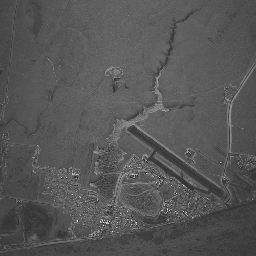

In [21]:
config = stac_asset.Config(
    http_headers={"authorization": f"Bearer {os.environ.get('UMBRA_API_TOKEN')}" }
)

item = gf.iloc[0]
img = await stac_asset.read_href(item.assets['thumbnail']['href'], config=config)
print(item.id)
Image(img)

## Point Search

In [22]:
# Search based on single point

# For example, is this bistatic pair public?...
# http://umbra-open-data-catalog.s3.amazonaws.com/sar-data/tasks/ad%20hoc/bistatic/tarbela_dam/2024-02-20-16-57-20.tif
# No, seems it's not in the catalog

aoi_as_dict = {
        "coordinates": [
          72.698,
          34.099
        ],
        "type": "Point"
      }

cql2filter = {
    "op": "=",
    "args": [
      {
        "property": "umbra:open-data-catalog"
      },
      True
    ]
  }

limit_results=2000

stac_search = archive.search(
    #filter=cql2filter,
    max_items=limit_results,
    limit=limit_results,
    intersects=aoi_as_dict,
)

items = stac_search.item_collection()
gf = items_to_dataframe(items)
len(gf)

2

In [23]:
gf.iloc[0]

assets                                      {'thumbnail': {'description': 'Low-resolution ...
bbox                                        {'xmin': 72.6741499645369, 'ymin': 34.05658251...
collection                                                                          umbra-sar
geometry                                    POLYGON Z ((72.73966216664009 34.1003607578395...
id                                                       f5c610ed-8880-49a0-880c-12b2296201e8
links                                       [{'href': 'https://api.canopy.umbra.space/arch...
stac_extensions                             [https://stac-extensions.github.io/view/v1.0.0...
stac_version                                                                            1.1.0
type                                                                                  Feature
created                                                      2024-03-06 19:57:37.840927+00:00
datetime                                                    